In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
import data
import pickle as pkl
from tqdm import tqdm
import train_reg
#df = data.get_tracks() # note: different Xs can be different shapes
#df = data.remove_invalid_tracks(df)
#df = data.preprocess(df)
#df = data.add_outcome(df)
#n = df.shape[0]

Using TensorFlow backend.
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/linux/anaconda3.7/lib/pytho

In [2]:
df = data.get_data()
df = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots

X_first_sig_frac = []
X_last_sig_frac = []
X_sig_mean_frac = []
X_sig_exist = []
X_min_time_frac = []
X_fall_below_mean_time = []

for i in range(len(df)):
    track = df.iloc[i]
    X_sig = np.where(track['X'] > track['X_mean'] + 1*track['X_std'])[0]
    X_min_time_frac.append(np.argmin(track['X'])/track['lifetime'])
    below_mean_after_peak = np.where(track['X'][track['X_peak_idx']:] < track['X_mean'])[0]
    if len(below_mean_after_peak)>0:
        X_fall_below_mean_time.append(np.min(below_mean_after_peak)/track['lifetime'])
    else:
        X_fall_below_mean_time.append(1-track['X_peak_idx']/track['lifetime'])
        
    if len(X_sig) >= 1:
        X_first_sig_frac.append(min(X_sig)/track['lifetime'])
        X_last_sig_frac.append(max(X_sig)/track['lifetime'])
        X_sig_mean_frac.append(np.mean(X_sig)/track['lifetime'])
        X_sig_exist.append(True)
    else:
        X_first_sig_frac.append(0.36)
        X_last_sig_frac.append(0.80)
        X_sig_mean_frac.append(0.59)
        X_sig_exist.append(False)
df['X_first_sig_frac'] = X_first_sig_frac
df['X_last_sig_frac'] = X_last_sig_frac
df['X_sig_mean_frac'] = X_sig_mean_frac
df['X_sig_exist'] = X_sig_exist
df['X_min_time_frac'] = X_min_time_frac
df['X_fall_below_mean_time'] = X_fall_below_mean_time

In [75]:
outcome_def = 'Y_peak_time_frac_diff'
df[outcome_def] = df['Y_peak_time_frac'] - df['X_peak_time_frac']
#df = df[df['X_sig_exist'] == True]
out_dir = f'results/regression/{outcome_def}'
os.makedirs(out_dir, exist_ok=True)
feat_names = data.get_feature_names(df)
feat_names = [x for x in feat_names 
              if not x.startswith('sc_') 
              and not x.startswith('nmf_')
              and not x in ['center_max', 'left_max', 'right_max', 'up_max', 'down_max',
                           'X_max_around_Y_peak', 'X_max_after_Y_peak', 'X_max_diff']
              and not x.startswith('pc_')
#               and not 'slope' in x
             ]
feat_names = [x for x in feat_names if '_tf_smooth' not in x]
#feat_names = ['X_peak_time_frac']

In [76]:
feat_names

['total_displacement',
 'mean_square_displacement',
 'lifetime',
 'lifetime_extended',
 'X_max',
 'X_max_extended',
 'X_min',
 'X_mean',
 'X_std',
 'X_peak_time_frac',
 'slope_end',
 'X_peak_last_15',
 'X_peak_last_5',
 'rise',
 'fall',
 'rise_extended',
 'fall_extended',
 'fall_late_extended',
 'fall_final',
 'rise_slope',
 'fall_slope',
 'rise_local_3',
 'fall_local_3',
 'rise_local_11',
 'fall_local_11',
 'max_diff',
 'min_diff',
 'fall_imp',
 'X_tf',
 'X_first_sig_frac',
 'X_last_sig_frac',
 'X_sig_mean_frac',
 'X_sig_exist',
 'X_min_time_frac',
 'X_fall_below_mean_time']

In [77]:
#outcome_def = 'Y_peak_time_frac_diff'
#out_dir = f'results/regression/Y_peak_time_frac_diff'
#df[outcome_def] = np.log(df['Y_max'])
#out_dir = f'results/regression/Y_max_log'
for model_type in tqdm(['rf', 'svm', 'linear', 'gb']):
    out_name = f'{model_type}'
                    #print(out_name)
    train_reg.train_reg(df, feat_names=feat_names[1:15] + feat_names[31:], model_type=model_type, 
                 outcome_def=outcome_def,
                 out_name=f'{out_dir}/{out_name}.pkl') 

 25%|██▌       | 1/4 [00:09<00:27,  9.30s/it]

[0.3807568576534287, 0.3385642599520876, 0.4415107595069362, 0.3305938753085822, 0.33634513695337687]


 50%|█████     | 2/4 [00:10<00:13,  6.97s/it]

[0.0902158465055165, 0.1283987312036421, 0.10009096847686606, 0.13053874292071788, 0.1408602930640961]
[0.34451376187764016, 0.31368207444202034, 0.4000709377878745, 0.3504950960706864, 0.34000768696088557]


100%|██████████| 4/4 [00:12<00:00,  5.09s/it]

[0.36865251183567715, 0.3287714392414971, 0.4338620437992225, 0.3587124263476973, 0.3442982473636179]


In [78]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['r2'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r

,cv_accuracy_by_cell,r2
model_type,,
gb,"[0.36865251183567715, 0.3287714392414971, 0.43...",0.362
rf,"[0.3807568576534287, 0.3385642599520876, 0.441...",0.359
linear,"[0.34451376187764016, 0.31368207444202034, 0.4...",0.347
ridge,"[0.27057800841012913, 0.2519835741609897, 0.31...",0.301
svm,"[0.0902158465055165, 0.1283987312036421, 0.100...",0.120
dt,"[-0.3754075984574454, -0.8550746872676571, -0....",-0.490
mlp2,"[-2896.828116664122, -93273.4952796763, -45862...",-33651.147


Text(0, 0.5, 'residual')

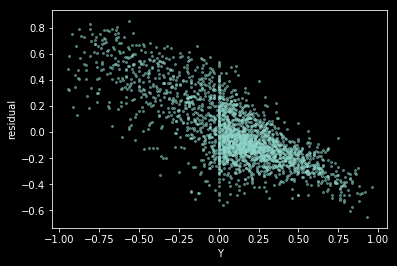

In [67]:
out_name=f'{out_dir}/gb.pkl'
d = pkl.load(open(out_name, 'rb'))
plt.scatter(d['y'], np.array(d['y_preds']) - d['y'], alpha=.5, s=4)
plt.xlabel("Y")
plt.ylabel('residual')